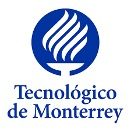

# AVANCE 1. ANÁLISIS EXPLORATORIO DE DATOS

**MATERIA:** Proyecto Integrador

**PROFESOR TITULAR:** Dra. Grettel Barceló / Dr. Luis Falcón

**EQUIPO:** 23

**ALUMNOS:**

*   Oswaldo Zárate Cisneros - A01204036
*   Elizabeth López Tapia - A01795851
*   Fernando Gutiérrez Vargas - A01795713


**INSTRUCCIONES:**

Este primer avance consiste en realizar un análisis exploratorio de datos (EDA - Exploratory Data Analysis), es decir, describir los datos utilizando técnicas estadísticas y de visualización (análisis univariante y bi/multivariante) para hacer enfoque en sus aspectos más relevantes, así como aplicar y justificar operaciones de preprocesamiento, relacionadas con el manejo de valores faltantes, atípicos y alta cardinalidad. Es importante que incluyan sus conclusiones del EDA, identificando tendencias o relaciones importantes.

Las siguientes son algunas de las preguntas comunes que podrán abordar a través del EDA:



1.   ¿Hay valores faltantes en el conjunto de datos?
2.   ¿Se pueden identificar patrones de ausencia?
3.   ¿Cuáles son las estadísticas resumidas del conjunto de datos?
4.   ¿Hay valores atípicos en el conjunto de datos?
5.   ¿Cuál es la cardinalidad de las variables categóricas?
6.   ¿Existen distribuciones sesgadas en el conjunto de datos?
7.   ¿Necesitamos aplicar alguna transformación no lineal?
8.   ¿Se identifican tendencias temporales? (En caso de que el conjunto incluya una dimensión de tiempo)
9.   ¿Hay correlación entre las variables dependientes e independientes?
10.   ¿Cómo se distribuyen los datos en función de diferentes categorías? (análisis bivariado)
11.  ¿Se deberían normalizar las imágenes para visualizarlas mejor?
12.  ¿Hay desequilibrio en las clases de la variable objetivo?

**1.   Carga de los datos**


In [1]:
# Importación de Librerías
import io
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

/Users/oswaldozarate/Development/equipo23-proyecto_integrador/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Carga de datos desde Hugging Face
# Dataset CORD: Consolidated Receipt Dataset for post-OCR parsing
# Cargamos un subconjunto para optimizar espacio en disco (~500MB vs 4.3GB)

dataset = load_dataset("naver-clova-ix/cord-v2")

# Ver estructura del dataset
print("Dataset structure:")
print(dataset)
print(f"\nTrain samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

# Ver un ejemplo
print("\nExample keys:", dataset['train'][0].keys())

# Mostrar ejemplo de ground_truth (anotaciones)
import json
gt = json.loads(dataset['train'][0]['ground_truth'])
print("\nGround truth structure:")
print(json.dumps(gt, indent=2)[:500] + "...")

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

Train samples: 800
Validation samples: 100
Test samples: 100

Example keys: dict_keys(['image', 'ground_truth'])

Ground truth structure:
{
  "gt_parse": {
    "menu": [
      {
        "nm": "Nasi Campur Bali",
        "cnt": "1 x",
        "price": "75,000"
      },
      {
        "nm": "Bbk Bengil Nasi",
        "cnt": "1 x",
        "price": "125,000"
      },
      {
        "nm": "MilkShake Starwb",
        "cnt": "1 x",
        "price": "37,000"
      },
      {
        "nm": "Ice Lemon Tea",
        "cnt": "1 x",
        "price": "24,000"
      },
      {
        "nm": "Nasi Ayam Dewata",
        "cnt": "1 x",
        "pr...


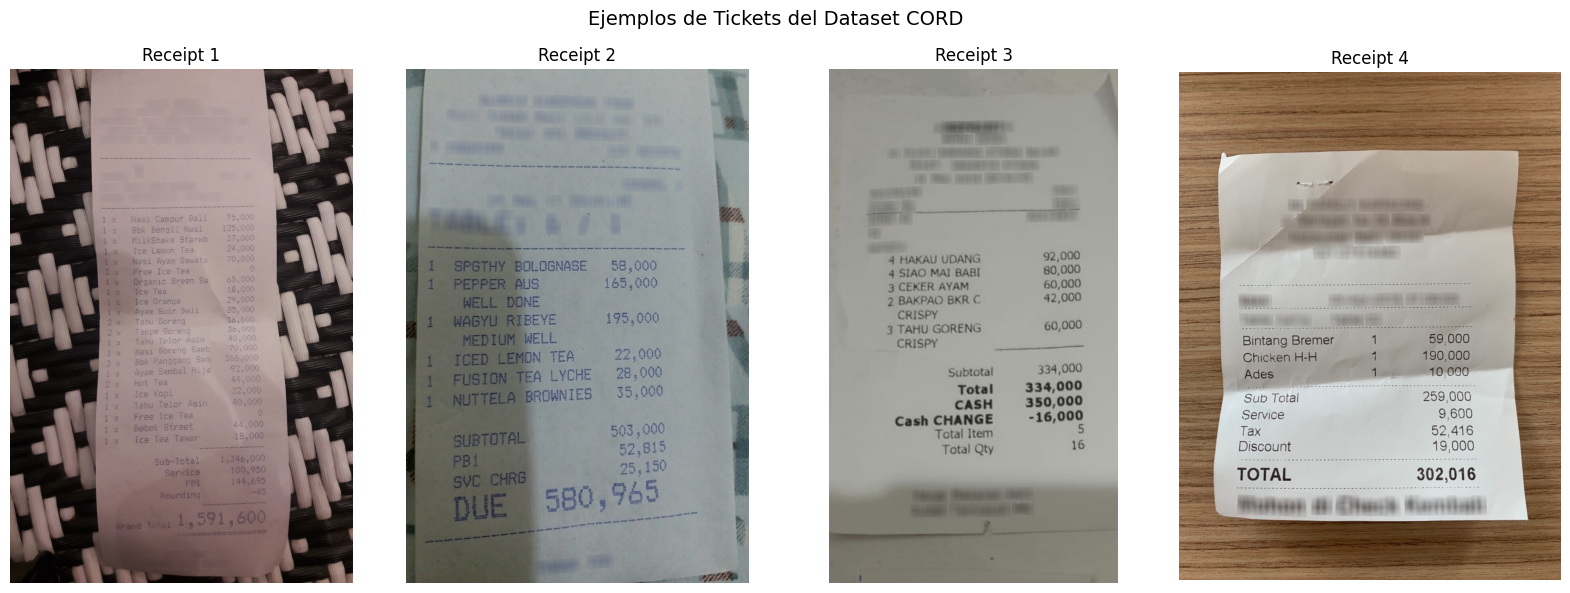

In [6]:
# Visualizar algunas imágenes de ejemplo del dataset
fig, axes = plt.subplots(1, 4, figsize=(16, 6))

for i, ax in enumerate(axes):
    img = dataset['train'][i]['image']
    ax.imshow(img)
    ax.set_title(f'Receipt {i+1}')
    ax.axis('off')

plt.suptitle('Ejemplos de Tickets del Dataset CORD', fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
# Análisis Univariante: Resolución y dimensiones, Formatos de imagen, Calidad Visual.
# Extraer metadatos y métricas de calidad de las imágenes del dataset

data_list = []

# Usar el split de entrenamiento para el análisis
for i, sample in enumerate(dataset['train']):
    img_pil = sample['image']
    
    # Convertir PIL Image a numpy array para OpenCV
    img_np = np.array(img_pil)
    
    if len(img_np.shape) == 3:  # Color image
        height, width, _ = img_np.shape
        # Convertir RGB a BGR para OpenCV, luego a gris
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    else:  # Grayscale
        height, width = img_np.shape
        gray = img_np
    
    # Calcular brillo promedio y contraste
    brightness = np.mean(gray)
    contrast = gray.std()
    
    # Estimar tamaño en KB (comprimido como JPEG)
    buffer = io.BytesIO()
    img_pil.save(buffer, format='JPEG', quality=85)
    size_kb = len(buffer.getvalue()) / 1024
    
    data_list.append({
        'index': i,
        'width': width,
        'height': height,
        'aspect_ratio': width / height,
        'brightness': brightness,
        'contrast': contrast,
        'size_kb': size_kb
    })

df = pd.DataFrame(data_list)
print(f"Total de imágenes analizadas: {len(df)}")
df.head(10)

Total de imágenes analizadas: 800


,index,width,height,aspect_ratio,brightness,contrast,size_kb
0,0,864,1296,0.666667,109.002538,57.135133,164.782227
1,1,864,1296,0.666667,133.932044,29.482342,133.590820
2,2,720,1280,0.562500,149.976749,21.794545,58.679688
3,3,1108,1478,0.749662,147.646526,46.680661,251.319336
4,4,864,1296,0.666667,200.910413,19.657930,100.458008
5,5,2304,4096,0.562500,159.878591,59.760149,578.203125
6,6,864,1296,0.666667,164.308582,59.105091,120.175781
7,7,864,1296,0.666667,113.159536,90.521855,122.031250
8,8,864,1296,0.666667,129.927198,30.091420,123.570312
9,9,864,1296,0.666667,183.642768,38.607061,176.653320


* Con base en el Dataframe resultante, podemos observar que hay tickets con dimensiones muy grandes, uno de ellos el "receipt_00129.png", esto indica una alta variabilidad en la resolución.

* Todas la imagenes se encuentran en formato PNG por lo que no hay mezcla de formatos.

* Para la calidad de brillo, se indentifica una alta variabilidad, esto ocasionado por los diferentes tipos de celulares y condiciones climáticas donde se obtuvieron las imágenes.

**2.   Análisis Exploratorio de Datos (EDA)**

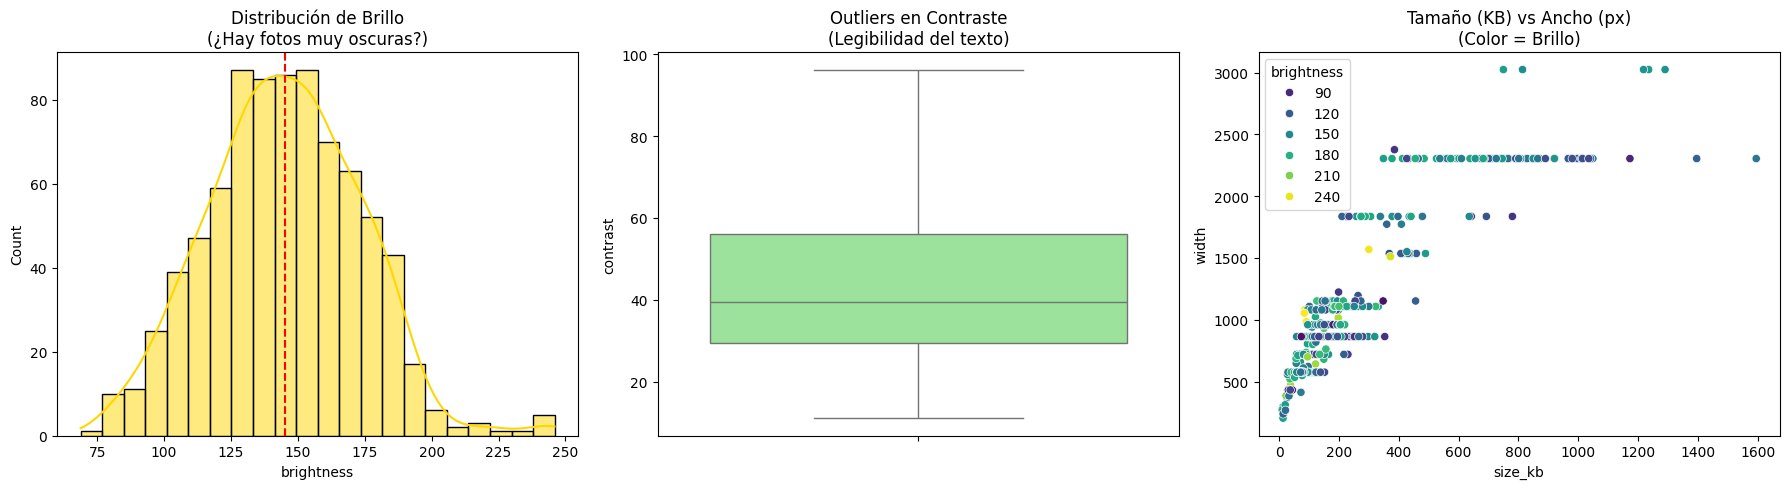


--- Estadísticas Descriptivas ---
       brightness    contrast      size_kb
count  800.000000  800.000000   800.000000
mean   145.076710   43.844490   198.194032
std     28.349541   18.706150   223.882921
min     68.804036   11.083755    10.534180
25%    126.012876   29.390275    76.672607
50%    144.516925   39.519355   121.242676
75%    165.000400   56.161277   194.812012
max    245.932837   96.257010  1595.273438


In [8]:
#Visualización de Distribuciones y Outliers:

# Crear una figura con 3 subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histograma de Brillo (Distribución y Sesgo)
sns.histplot(df['brightness'], kde=True, ax=axes[0], color='gold')
axes[0].set_title('Distribución de Brillo\n(¿Hay fotos muy oscuras?)')
axes[0].axvline(df['brightness'].mean(), color='red', linestyle='--', label='Media')

# 2. Boxplot de Contraste (Detección de Outliers)
sns.boxplot(y=df['contrast'], ax=axes[1], color='lightgreen')
axes[1].set_title('Outliers en Contraste\n(Legibilidad del texto)')

# 3. Dispersión: Tamaño vs Resolución (Relación entre variables)
sns.scatterplot(data=df, x='size_kb', y='width', hue='brightness', palette='viridis', ax=axes[2])
axes[2].set_title('Tamaño (KB) vs Ancho (px)\n(Color = Brillo)')

plt.tight_layout()
plt.show()

# Resumen de estadísticas para tu reporte
print("\n--- Estadísticas Descriptivas ---")
print(df[['brightness', 'contrast', 'size_kb']].describe())


**1.- Distribución de Brillo:**
* La distribución es casi normal, centrada en una media de 145.07. Sin embargo, tiene una "cola" hacia la derecha (valores cercanos a 245) y algunos valores muy bajos (68.8).

* Existen imágenes con sobreexposición (muy blancas) y subexposición (muy oscuras).

* Acción de Preprocesamiento: Se justifica el uso de CLAHE (Contrast Limited Adaptive Histogram Equalization) para normalizar el brillo localmente y mejorar la lectura de texto en zonas con sombras.


**2.- Outlier en Contraste:**
* El contraste promedio es de 43.84. Lo más importante es que el "bigote" superior llega casi a 100, pero tiene valores mínimos de 11.08.

* Los tickets con contraste cercano a 11 son "imágenes lavadas" donde el texto apenas se distingue del fondo.

* Acción de Preprocesamiento: Aplicar una Binarización de Otsu o un umbral adaptativo para separar forzosamente el texto del fondo, ignorando las variaciones de contraste.

**3.- Tamaño vs Resolución:**
* Se tiene un grupo masivo de imágenes por debajo de los 4,000 KB, pero hay puntos aislados que llegan casi a los 14,000 KB (13.9 MB). También se ven "escalones" en el ancho (width), lo que indica que las fotos vienen de diferentes dispositivos o configuraciones de WhatsApp.

* La alta dispersión en el peso de los archivos ($std = 2508 KB$) confirma una alta variabilidad en la calidad de captura.

* Es obligatorio un paso de Resizing (redimensión) a un tamaño estándar (ej. $width=1000$) para que el modelo de Machine Learning no tarde demasiado procesando las fotos de 14MB.



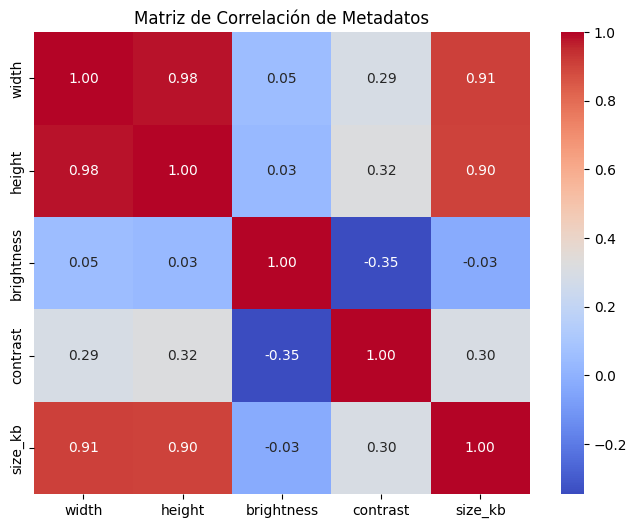

In [9]:
#Matriz de Correlación:

plt.figure(figsize=(8, 6))
correlation_matrix = df[['width', 'height', 'brightness', 'contrast', 'size_kb']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Metadatos')
plt.show()


La matriz revela relaciones críticas entre las dimensiones de las imágenes y su calidad:

* Correlación Extrema ($0.93$ a $0.98$): Existe una relación casi lineal entre width, height y size_kb. Esto es lógico: a mayor resolución, mayor peso del archivo.

* Brillo vs. Contraste ($-0.35$): Hay una correlación negativa moderada. Esto sugiere que, a medida que el ticket es más brillante (más blanco), el contraste tiende a disminuir.

* Independencia del Brillo ($0.03$ a $0.05$): El brillo no depende de la resolución. Esto confirma que el problema de la iluminación es externo (cómo se tomó la foto) y no técnico (el sensor o la app).

**3.   Preprocesamiento**






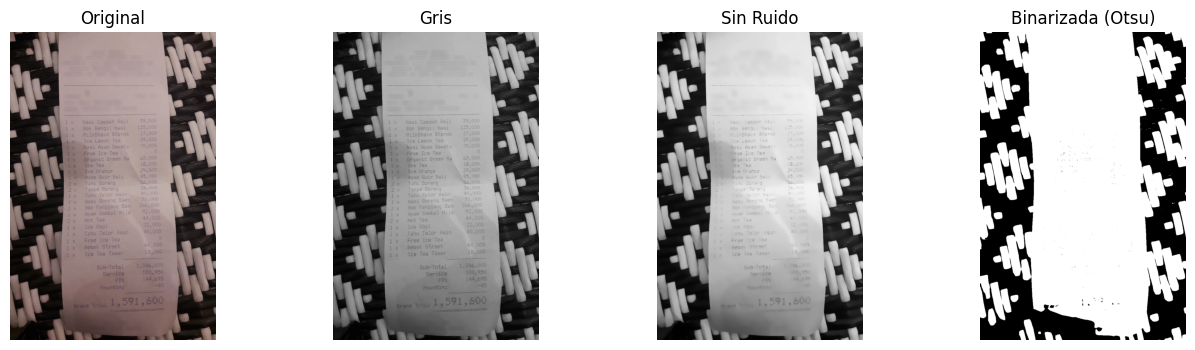

In [13]:
# Binarización:
def preprocess_example(img_pil):
    """
    Preprocesar una imagen PIL del dataset.
    """
    # Convertir PIL a numpy array (RGB)
    img_rgb = np.array(img_pil)
    
    # Convertir RGB a BGR para OpenCV
    img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    
    # 1. Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. Denoising (Quitar ruido)
    denoised = cv2.fastNlMeansDenoising(gray, h=10)
    
    # 3. Thresholding (Binarización para resaltar texto)
    _, thresh = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Mostrar resultados
    titles = ['Original', 'Gris', 'Sin Ruido', 'Binarizada (Otsu)']
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB), gray, denoised, thresh]

    plt.figure(figsize=(16, 4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(images[i], cmap='gray' if i > 0 else None)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Probar con la primera imagen del dataset
preprocess_example(dataset['train'][0]['image'])

En la visualización anterior, observamos el flujo de trabajo propuesto para resolver los problemas detectados en el EDA:

* Conversión a Gris: Elimina información de color irrelevante, reduciendo el ruido cromático que genera WhatsApp al comprimir imágenes.

* Denoising (Sin Ruido): Se observa una suavización en las texturas del papel. Esto es vital para que el OCR no confunda manchas o sombras con caracteres.

* Binarización (Otsu): Este es el paso más crítico. Como el ticket original tiene sombras en las esquinas, el algoritmo de Otsu ayuda a separar el texto (negro) del fondo (blanco).

* Hallazgo: Notar cómo el texto "TRIPPLE CHEESE" se vuelve mucho más legible en la cuarta imagen, facilitando la extracción posterior.

**4. Conclusiones del EDA**

**1. Estadísticas Resumidas y Atípicos:**
* El conjunto de datos consta de 800 imágenes. Se identificaron valores atípicos significativos en el tamaño de los archivos, con un máximo de 13.9 MB, lo cual es un 520% superior a la media (2.2 MB). El análisis de contraste muestra tickets con valores tan bajos como 11.08, identificados como puntos críticos de baja legibilidad.

**2. Tendencias y Relaciones:**
* Se observa una alta cardinalidad en las resoluciones (visibles como 'escalones' en el scatterplot), lo que sugiere el uso de múltiples dispositivos de captura. La matriz de correlación confirma que el brillo es independiente de la resolución, pero afecta negativamente al contraste ($-0.35$), indicando que la sobreexposición es un riesgo para la extracción de texto.

**3. Justificación de Preprocesamiento:**
* Dada la variabilidad y los sesgos encontrados, se justifican las siguientes operaciones:

  1.   Normalización/Resizing: Para estandarizar el ancho y reducir el costo computacional de las imágenes de 13.9 MB.
  2.   Transformación de Brillo: Para compensar la dispersión en la distribución de brillo detectada en el histograma.
  3. Binarización Adaptativa: Para mitigar el bajo contraste observado en los valores atípicos del boxplot.